# Lane detection using deep convolutional neural network autoencoder

Starting this project, I have a hypothesis that deep convolutional neural network will be able to find road structure.

Then I will label real road videos and will test it on video from Udacity. I expect to find train videos on youtube and I expect that 1 000 labeled images will be enough for success. I estimate labeling effort as highest effort in whole project - I expect to spend ~11 hours on this, labeling 90 images per hour (2 images per minute for 45 minutes and 15 minutes rest).

To find out how good model is and how many actual images I need, I will solve simplier task first: I will first prove simplier hypothesis: sumulate a bunch of road images and will train dCNN autoencoder to recognize it from image back to model.

I will simulate only one lane (in which car is currently moving) for purpose of simplicity.

Udacity challenge has three videos:
1. "project_video.mp4" has solid yellow left line and dash-dot white right line. Lines are curved with one curve direction or straight 
2. "challenge_video.mp4" same as previous but with changing lightning conditions
3. "harder_challenge_video.mp4" has double solid yellow left line and solid right line, lighning conditions are changing very fast. Lines are curved with two extremums (which means it cannot be described with parabola, but with cubic polynomial).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
image_width = 224
image_height = 224

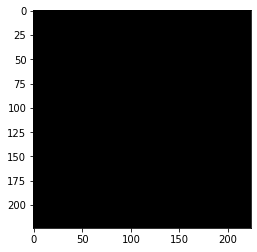

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def make_blank_image(width: int, height: int):
    return np.zeros((height, width, 3), dtype=np.uint8)


image = make_blank_image(width=image_width, height=image_height)

plt.imshow(image)

In [4]:
import math
import cv2

class Point:
    def __init__(self, x: float, y: float):
        self.x: float = x
        self.y: float = y

    def distance_to(self, point) -> float:
      return math.sqrt((self.x - point.x)**2 + (self.y - point.y)**2)
            
    def __str__(self):
        return "({}, {})".format(self.x, self.y)


    def present(self, image):
      image_height = image.shape[0]
      image_width = image.shape[1]

      cv2.circle(image, center=(int(self.x * image_width), int(self.y * image_height)), radius=2, color=[255, 0, 0], thickness=2)

(0.3, 0.4)
0.5


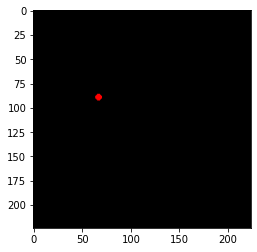

In [5]:
point = Point(x=0.3, y=0.4)
print(point)

another_point = Point(x=0, y=0)
print(point.distance_to(point=another_point))

image = make_blank_image(width=image_width, height=image_height)

point.present(image)

plt.imshow(image)

In [6]:
from enum import Enum

class SimulatedLineColor(Enum):
  YELLOW = 1
  WHITE = 2

class SimulatedLineStroke(Enum):
  SOLID = 1
  DASHED = 2

class SimulatedLineQuantity(Enum):
  SINGLE = 1
  DOUBLE = 2

In [7]:
import cv2

class SimulatedLineSegment:
  def __init__(
      self,
      start_point: Point,
      end_point: Point,
      color: SimulatedLineColor,
      width: float
  ):
    self.start_point: Point = start_point
    self.end_point: Point = end_point
    self.color: SimulatedLineColor = color
    self.width: float = width

  def __str__(self):
    return "{} - {} {} width={}".format(self.start_point, self.end_point, self.color, self.width)

  def convert_point_to_cv2_point(self, point: Point, image_width: int, image_height: int) -> []:
    return (
      int(point.x * image_width),
      int(point.y * image_height)
    )

  def get_rgb_color(self, color: SimulatedLineColor):
    if color == SimulatedLineColor.WHITE:
      return [255, 255, 255]
    elif color == SimulatedLineColor.YELLOW:
      return [255, 255, 0]
    else:
      raise ValueError('SimulatedLineSegment get_rgb_color unknown color {}'.format(color))

  def present(self, image):
      image_height = image.shape[0]
      image_width = image.shape[1]

      line_thickness = max(image_height, image_width) * self.width

      start_point_cv2 = self.convert_point_to_cv2_point(point=self.start_point, image_width=image_width, image_height=image_height)
      
      end_point_cv2 = self.convert_point_to_cv2_point(point=self.end_point, image_width=image_width, image_height=image_height)

      color = self.get_rgb_color(color=self.color) 

      cv2.line(image, pt1=start_point_cv2, pt2=end_point_cv2, color=color, thickness=int(line_thickness))

(0, 0) - (1, 1) SimulatedLineColor.YELLOW width=0.01


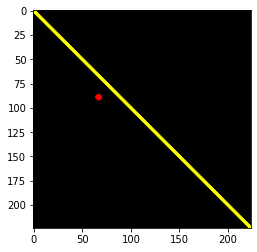

In [8]:
simulated_line_segment = SimulatedLineSegment(
    start_point=Point(x=0, y=0),
    end_point=Point(x=1, y=1),
    color=SimulatedLineColor.YELLOW,
    width=0.01
)

print(simulated_line_segment)

simulated_line_segment.present(image=image)

plt.imshow(image)

In [9]:
import numpy as np

class SimulatedLine:
    def __init__(
        self,
        points: [Point],
        color: SimulatedLineColor,
        stroke: SimulatedLineStroke,
        quantity: SimulatedLineQuantity,
        width: int
      ):
        self.points: [Point] = points
        self.polynomial_coefficients: [float] = self.calculate_polynomial_coefficients_by_points(
            points=points
        )
        self.color: SimulatedLineColor = color
        self.stroke: SimulatedLineStroke = stroke
        self.quantity: SimulatedLineQuantity = quantity
        self.width: float = width

        self.segments = self.make_segments()

    def make_polynomial_equation_for_point(self, point: Point, number_of_points: int) -> []:
      result_A = []

      highest_degree = number_of_points - 1

      for i in range(0, highest_degree):
        term_power = highest_degree - i
        coefficient = point.x ** term_power
        result_A.append(coefficient)

      result_A.append(1)

      result_b = point.y

      return result_A, result_b

    def make_linear_equation_by_points(self, points: [Point]) -> ([[]], []):
      result_A = []
      result_b = []

      number_of_points = len(points)

      for point in points:
        polynomial_A, polynomial_b = self.make_polynomial_equation_for_point(point=point, number_of_points=number_of_points)
        result_A.append(polynomial_A)
        result_b.append(polynomial_b)

      return result_A, result_b

    def solve_linear_equation(self, A: [[]], b: []) -> []:
      invA = np.linalg.inv(A)

      result = np.dot(invA, b)

      return result

    def calculate_polynomial_coefficients_by_points(self, points: [Point]) -> []:
      A, b = self.make_linear_equation_by_points(points=points)
      solution = self.solve_linear_equation(A=A, b=b)
      result = solution.tolist()

      return result


    def get_point_at_x(self, x: float) -> Point:
      polynomial_coefficients = self.polynomial_coefficients

      equation_terms = []
      for index, polynomial_coefficient in enumerate(polynomial_coefficients):
          degree = len(polynomial_coefficients) - index - 1
      
          equation_term = polynomial_coefficient * (x ** degree)
              
          equation_terms.append(equation_term)

      y = sum(equation_terms)

      return Point(x=x, y=y)

    def make_segments(self):
      result = []

      step = 0.001
      min_distance = 0.10

      min_x = min([point.x for point in self.points])
      max_x = max([point.x for point in self.points])

      previous_x = min_x
      previous_point = self.get_point_at_x(x=previous_x)

      current_x = min_x + step

      while (current_x <= max_x):
        current_point = self.get_point_at_x(x=current_x)

        distance = previous_point.distance_to(point=current_point)

        if distance >= min_distance:
          segment = SimulatedLineSegment(
              start_point=previous_point,
              end_point=current_point,
              color=self.color,
              width=self.width
          )

          result.append(segment)

          previous_x = current_x
          previous_point = self.get_point_at_x(x=previous_x)

        current_x = current_x + step

      segment = SimulatedLineSegment(
          start_point=previous_point,
          end_point=current_point,
          color=self.color,
          width=self.width
      )
      result.append(segment)

      return result
    
    def __str__(self):
        polynomial_coefficients = self.polynomial_coefficients
        polynomial_equation_parts = []
        for index, polynomial_coefficient in enumerate(polynomial_coefficients):
            degree = len(polynomial_coefficients) - index - 1
            
            if degree > 1:
                polynomial_equation_part = "{}*x^{}".format(polynomial_coefficient, degree)
            if degree == 1:
                polynomial_equation_part = "{}*x".format(polynomial_coefficient)
            elif degree == 0:
                polynomial_equation_part = "{}".format(polynomial_coefficient)
                
            polynomial_equation_parts.append(polynomial_equation_part)
        
        return "+".join(polynomial_equation_parts)

    def present_solid_line(self, image):
      for segment in self.segments:
        segment.present(image=image)

    def present_dashed_line(self, image):
      for i, segment in enumerate(self.segments):
        if i % 2 == 0:
          segment.present(image=image)

    def present(self, image):
      stroke = self.stroke

      # for point in self.points:
      #   point.present(image)

      if stroke == SimulatedLineStroke.SOLID:
        self.present_solid_line(image=image)
      elif stroke == SimulatedLineStroke.DASHED:
        self.present_dashed_line(image=image)
      else:
        raise ValueError('SimulatedLine present unknown stroke {}'.format(stroke))

    def convert_points_to_points_array(self):
      result = []
      for point in self.points:
        result.append(point.x)
        result.append(point.y)

      return result

    def y(self):
      points_array = self.convert_points_to_points_array()

      max_color = max([color.value for color in SimulatedLineStroke])
      color = self.color.value
      normalized_color = color / max_color

      max_stroke = max([stroke.value for stroke in SimulatedLineStroke])
      stroke = self.stroke.value
      normalized_stroke = stroke / max_stroke

      width = self.width

      return points_array + [normalized_color, stroke, width]


2.083333333333332*x^3+-3.7499999999999964*x^2+2.666666666666666*x+0.0


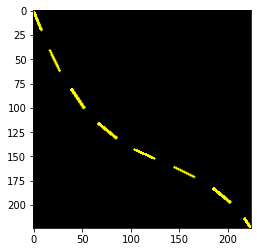

In [10]:
simulated_line = SimulatedLine(
    points=[
      Point(x=0.0, y=0.0),
      Point(x=0.2, y=0.4),
      Point(x=0.8, y=0.8),
      Point(x=1.0, y=1.0)
    ],
    color=SimulatedLineColor.YELLOW,
    stroke=SimulatedLineStroke.DASHED,
    quantity=SimulatedLineQuantity.SINGLE,
    width=0.01
)

print(simulated_line)

image = make_blank_image(width=image_width, height=image_height)

simulated_line.present(image=image)

plt.imshow(image)

In [11]:
class SimulatedLane:
  def __init__(self, left_line: SimulatedLine, right_line: SimulatedLine):
    self.left_line: SimulatedLine = left_line
    self.right_line: SimulatedLine = right_line

  def __str__(self):
    return "left line: {}\nright line: {}".format(self.left_line, self.right_line)

  def present(self, image):
    self.left_line.present(image)
    self.right_line.present(image)

  def segments_to_points(self, segments: [SimulatedLineSegment]):
    result = [segment.start_point for segment in segments]
    last_segment = segments[-1]
    result.append(last_segment.end_point)
    return result

  def get_points(self):
    left_line_segments = self.left_line.segments
    right_line_segments = self.right_line.segments
    left_line_points = self.segments_to_points(segments=left_line_segments)
    right_line_points_reversed = self.segments_to_points(segments=right_line_segments)[::-1]
    return left_line_points + right_line_points_reversed

  def present_filled(self, image):
    points = self.get_points()

    image_height = image.shape[0]
    image_width = image.shape[1]

    cv2_points = np.array([[int(point.x * image_width), int(point.y * image_height)] for point in points])
    
    cv2.fillPoly(image, [cv2_points], color=[0, 255, 0])

  def y(self):
    return self.left_line.y() + self.right_line.y()

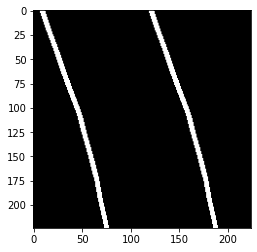

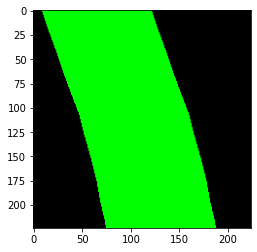

[0.04257100170168043, 0, 0.12521951893989594, 0.2378571226144393, 0.303816149844573, 0.8351127043129588, 0.3355858635972651, 1, 1.0, 1, 0.01563706078380016, 0.5425710017016805, 0, 0.6252195189398959, 0.2378571226144393, 0.8038161498445731, 0.8351127043129588, 0.835585863597265, 1, 1.0, 1, 0.016025285656086102]


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import random

class SimulatedLaneImageGenerator:
  def __init__(self, image_width: int, image_height: int):
    self.image_width: int = image_width
    self.image_height: int = image_height

  def get_random_middle_point(self, start_point: Point, end_point: Point, range_x_min: float, range_x_max: float):
    m = (start_point.y - end_point.y) / (start_point.x - end_point.x)
    b = start_point.y - m * start_point.x

    x = random.uniform(a=range_x_min, b=range_x_max)
    y = m * x + b

    return Point(x=x, y=y)

  def random_shift_y(self, point: Point, percent_range: float, start_point: Point, end_point: Point):
    shift_value = random.uniform(a=-percent_range, b=percent_range)
    shifted_y = point.y + shift_value

    return Point(x=point.x, y=shifted_y)

  def exchange(self, a, b) -> ():
    return (b, a)

  def make_left_points_for_curly_line(self, start_x: float, end_x: float) -> [Point]:
    start_point = Point(x=start_x, y=0)
    end_point = Point(x=end_x, y=1)

    percent_range=0.2

    middle_point_1_range_x_min = start_point.x + (end_point.x - start_point.x) * 0.1
    middle_point_1_range_x_max = start_point.x + (end_point.x - start_point.x) * 0.3
    middle_point_1 = self.get_random_middle_point(
      start_point=start_point, 
      end_point=end_point, 
      range_x_min=middle_point_1_range_x_min,
      range_x_max=middle_point_1_range_x_max
    )
    middle_point_1 = self.random_shift_y(
      point=middle_point_1,
      percent_range=percent_range,
      start_point=start_point,
      end_point=end_point
    )

    middle_point_2_range_x_min = end_point.x - (end_point.x - start_point.x) * 0.3
    middle_point_2_range_x_max = end_point.x - (end_point.x - start_point.x) * 0.1
    middle_point_2 = self.get_random_middle_point(
      start_point=start_point,
      end_point=end_point,
      range_x_min=middle_point_2_range_x_min,
      range_x_max=middle_point_2_range_x_max
    )
    middle_point_2 = self.random_shift_y(
      point=middle_point_2,
      percent_range=percent_range,
      start_point=start_point,
      end_point=end_point
    )

    return [start_point, middle_point_1, middle_point_2, end_point]

  def generate_random_points_for_left_curly_line(self):
    start_x = random.uniform(a=0, b=0.5)
    end_x = random.uniform(a=0, b=0.5)

    start_x_less_than_end_x = start_x < end_x
    if not start_x_less_than_end_x:
      start_x, end_x = self.exchange(start_x, end_x)

    if abs(end_x - start_x) < 0.1:
      end_x = min(end_x + 0.1, 1.0)
      start_x = max(start_x - 0.1, 0.0)

    return self.make_left_points_for_curly_line(start_x=start_x, end_x=end_x)

  def make_right_lane_points_from_left_line_points(self, left_line_points: [Point]) -> [Point]:
    return [Point(x=point.x + 0.5,y=point.y) for point in left_line_points]

  def generate_random_simulated_line_from_points(self, points: [Point]) -> SimulatedLine:
    color = random.choice(list(SimulatedLineColor))
    stroke = random.choice(list(SimulatedLineStroke))
    quantity = random.choice(list(SimulatedLineQuantity))
    width = random.uniform(0.005, 0.02)

    return SimulatedLine(points=points, color=color, stroke=stroke, quantity=quantity, width=width) 

  def generate_random_simulated_lane(self):
    left_line_points = self.generate_random_points_for_left_curly_line()
    left_line = self.generate_random_simulated_line_from_points(points=left_line_points)

    right_line_points = self.make_right_lane_points_from_left_line_points(left_line_points=left_line_points)

    right_line = self.generate_random_simulated_line_from_points(points=right_line_points)

    return SimulatedLane(left_line=left_line, right_line=right_line)

  def generate(self):
    image_width = self.image_width
    image_height = self.image_height
            
    simulated_lane = self.generate_random_simulated_lane()

    X_image = make_blank_image(width=image_width, height=image_height)
    simulated_lane.present(image=X_image)

    y_image = make_blank_image(width=image_width, height=image_height)
    simulated_lane.present_filled(image=y_image)

    y_lane = simulated_lane.y()

    return X_image, y_image, y_lane

simulated_line_image_generator = SimulatedLaneImageGenerator(image_width=image_width, image_height=image_height)
X_image, y_image, y_lane = simulated_line_image_generator.generate()

plt.imshow(X_image)
plt.show()
plt.imshow(y_image)
plt.show()
print(y_lane)

In [13]:
from PIL import Image

def save_image(image, file_name: str):
    pil_image = Image.fromarray(image)
    pil_image.save(file_name)
    
save_image(image=X_image, file_name='X.png')
save_image(image=y_image, file_name='y.png')

In [14]:
!rm -rf ./data

In [15]:
import os
import csv


def save_y_lane(y_lane, file_name: str):
  with open(file_name, 'w') as csv_file:
      csv_writer = csv.writer(csv_file)
      csv_writer.writerow(y_lane)

def generate_data(image_width: int, image_height: int, image_quantity: int, folder: str):
    os.makedirs('./data', exist_ok=True)
    os.makedirs('./data/{}'.format(folder), exist_ok=True)
    os.makedirs('./data/{}/X'.format(folder), exist_ok=True)
    os.makedirs('./data/{}/y'.format(folder), exist_ok=True)
    
    simulated_line_image_generator = SimulatedLaneImageGenerator(image_width=image_width, image_height=image_height)
    for i in range(image_quantity):
        X_image, y_image, y_lane = simulated_line_image_generator.generate()
        save_image(image=X_image, file_name='./data/{}/X/{:05}.png'.format(folder, i))
        save_image(image=y_image, file_name='./data/{}/y/{:05}.png'.format(folder, i))
        save_y_lane(y_lane=y_lane, file_name='./data/{}/y/{:05}.csv'.format(folder, i))
        
def generate_train_data(image_width: int, image_height: int):
    generate_data(image_width=image_width, image_height=image_height, image_quantity=1000, folder='train')
        
generate_train_data(image_width=image_width, image_height=image_height)

def generate_valid_data(image_width: int, image_height: int):
    generate_data(image_width=image_width, image_height=image_height, image_quantity=100, folder='valid')
        
generate_valid_data(image_width=image_width, image_height=image_height)

In [16]:
def generate_test_data(image_width: int, image_height: int):
    generate_data(image_width=image_width, image_height=image_height, image_quantity=100, folder='test')
        
generate_test_data(image_width=image_width, image_height=image_height)

In [17]:
def load_images(folder: str):
    result = []
    for filename in sorted(os.listdir(folder)):
      if filename.endswith('.png'):
        image = cv2.imread(os.path.join(folder, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result.append(image)
    return np.array(result)

def load_y_lanes(folder: str):
    result = []
    for filename in sorted(os.listdir(folder)):
      if filename.endswith('.csv'):
        with open(os.path.join(folder, filename)) as csv_file:
          csv_reader = csv.reader(csv_file)
          for row in csv_reader:
            row_of_floats = [float(value) for value in row]
            result.append(row_of_floats)
    return np.array(result)
    
X_train = load_images(folder='./data/train/X') / 255.0
y_train = load_images(folder='./data/train/y') / 255.0
y_train_lanes = load_y_lanes(folder='./data/train/y')

X_valid = load_images(folder='./data/valid/X') / 255.0
y_valid = load_images(folder='./data/valid/y') / 255.0
y_valid_lanes = load_y_lanes(folder='./data/valid/y')

X_test = load_images(folder='./data/test/X') / 255.0
y_test = load_images(folder='./data/test/y') / 255.0
y_test_lanes = load_y_lanes(folder='./data/test/y')

In [18]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import losses

class Fill(Model):
    def __init__(self, image_width: int, image_height: int):
        super(Fill, self).__init__()
        number_of_channels = 3
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(image_height, image_width, number_of_channels, )),
            layers.Conv2D(8, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(8, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(8, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
#             layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.MaxPooling2D((2, 2), padding='same'),
        ])

        self.decoder = tf.keras.Sequential([
#             layers.Conv2D(128, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.Conv2D(128, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.Conv2D(128, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
#             layers.BatchNormalization(),
#             layers.Activation(activation='relu'),
#             layers.UpSampling2D((2, 2)),
            layers.Conv2D(64, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(64, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(64, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(32, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(32, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(16, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(16, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(8, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.Conv2D(8, kernel_size=3, strides=(1, 1), activation=None, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(number_of_channels, kernel_size=(3,3), activation='relu', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

fill_autoencoder = Fill(image_width=image_width, image_height=image_height)

In [19]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=1e-4)
fill_autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['acc'])

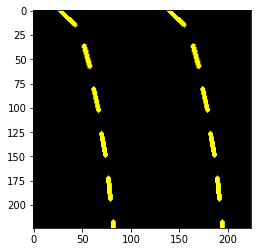

In [20]:
X_image = X_train[0]
plt.imshow(X_image)
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_learning_rate_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=3,
    min_delta=1e-5, 
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-5, 
    mode='min',
    verbose=1
)

fill_autoencoder.fit(X_train, y_train,
                epochs=1000,
                shuffle=True,
                batch_size=2,
                validation_data=(X_valid, y_valid),
                verbose=1, 
                callbacks=[
                    reduce_learning_rate_callback,
                    early_stopping_callback,
                ]
)

Epoch 1/1000
500/500 [==============================] - 7s 14ms/step - loss: 0.0510 - acc: 0.5609 - val_loss: 0.0119 - val_acc: 0.6815
Epoch 2/1000
500/500 [==============================] - 7s 13ms/step - loss: 0.0051 - acc: 0.6998 - val_loss: 0.0041 - val_acc: 0.7723
Epoch 3/1000
500/500 [==============================] - 7s 13ms/step - loss: 0.0031 - acc: 0.7995 - val_loss: 0.0028 - val_acc: 0.8584
Epoch 4/1000
500/500 [==============================] - 6s 13ms/step - loss: 0.0029 - acc: 0.8829 - val_loss: 0.0023 - val_acc: 0.9102
Epoch 5/1000
500/500 [==============================] - 7s 13ms/step - loss: 0.0020 - acc: 0.9273 - val_loss: 0.0019 - val_acc: 0.9365
Epoch 6/1000
500/500 [==============================] - 7s 13ms/step - loss: 0.0017 - acc: 0.9442 - val_loss: 0.0017 - val_acc: 0.9502
Epoch 7/1000
500/500 [==============================] - 7s 13ms/step - loss: 0.0015 - acc: 0.9566 - val_loss: 0.0014 - val_acc: 0.9621
Epoch 8/1000
500/500 [==============================] -

In [ ]:
fill_autoencoder.summary()

In [ ]:
y_pred = fill_autoencoder.predict(X_test)

In [ ]:
i = 3

plt.imshow(X_test[i])
plt.show()

plt.imshow(y_test[i])
plt.show()

prediction = y_pred[i]
plt.imshow(prediction, vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
np.amin(y_test[i])

In [ ]:
np.amin(prediction)

In [ ]:
np.amax(y_test[i])

In [ ]:
np.amax(prediction)

In [ ]:
class PolynomialCoefficientsModel(Model):
  def __init__(self, image_width: int, image_height: int, number_of_output_parameters: int):
    super(PolynomialCoefficientsModel, self).__init__()
    number_of_channels = 3

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(image_height, image_width, number_of_channels, )),
      layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(16, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(32, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.Conv2D(64, (3,3), activation=None, padding='same', strides=(1, 1)),
      layers.BatchNormalization(),
      layers.Activation(activation='relu'),
      layers.MaxPooling2D((2, 2), padding='same'),
      # layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.Conv2D(128, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.MaxPooling2D((2, 2), padding='same'),
      # layers.Conv2D(256, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.Conv2D(256, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.Conv2D(256, (3,3), activation=None, padding='same', strides=(1, 1)),
      # layers.BatchNormalization(),
      # layers.Activation(activation='relu'),
      # layers.MaxPooling2D((2, 2), padding='same'),
      layers.GlobalAveragePooling2D(),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dropout(0.2),
      layers.Dense(128),
      layers.Activation(activation='relu'), 
      layers.Dropout(0.2),
      layers.Dense(number_of_output_parameters),
      layers.Activation(activation='relu'), 
    ])                          
    
  def call(self, x):
    encoded = self.encoder(x)
    decoder = self.decoder(encoded)
    return decoder

number_of_parameters_describing_lane = y_train_lanes.shape[1]
print(number_of_parameters_describing_lane)
polynomial_coefficients_model = PolynomialCoefficientsModel(image_width=image_width, image_height=image_height, number_of_output_parameters=number_of_parameters_describing_lane)


In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=1e-4)
polynomial_coefficients_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_learning_rate_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=3,
    min_delta=1e-5, 
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-5, 
    mode='min',
    verbose=1
)

polynomial_coefficients_model.fit(X_train, y_train_lanes,
                epochs=1000,
                shuffle=True,
                batch_size=2,
                validation_data=(X_valid, y_valid_lanes),
                verbose=1, 
                callbacks=[
                    reduce_learning_rate_callback,
                    early_stopping_callback,
                ]
)

In [ ]:
y_pred_lanes = polynomial_coefficients_model.predict(X_test)

In [ ]:
i = 2

print(y_test_lanes[i])

prediction = y_pred_lanes[i]
print(prediction)

In [ ]:
def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)


def make_points_from_points_array(points_array: [float]) -> [Point]:
  result = []
  for x, y in pairwise(points_array):
    point = Point(x=x, y=y)
    result.append(point)

  return result

def make_line_from_prediction(points_array: [float]) -> [SimulatedLine]:
  line_points = make_points_from_points_array(points_array=points_array)

  return SimulatedLine(points=line_points, color=SimulatedLineColor.WHITE, stroke=SimulatedLineStroke.SOLID, quantity=SimulatedLineQuantity.SINGLE, width=0.01)
  
def construct_lane_from_prediction(prediction: [float]) -> SimulatedLane:
  left_line_points_array = prediction[0:8]
  left_line = make_line_from_prediction(points_array=left_line_points_array)

  right_line_points_array = prediction[11:19]
  right_line = make_line_from_prediction(points_array=right_line_points_array)

  return SimulatedLane(left_line=left_line, right_line=right_line)

plt.imshow(X_test[i])
plt.show()

plt.imshow(y_test[i])
plt.show()

y_test_lane = construct_lane_from_prediction(prediction=y_test_lanes[i])
image = make_blank_image(width=image_width, height=image_height)
y_test_lane.present_filled(image=image)
lane_points = y_test_lane.left_line.points + y_test_lane.right_line.points
for point in lane_points:
  point.present(image=image)
plt.imshow(image)
plt.show()

y_pred_lane = construct_lane_from_prediction(prediction=prediction)
image = make_blank_image(width=image_width, height=image_height)
y_pred_lane.present_filled(image=image)
lane_points = y_pred_lane.left_line.points + y_pred_lane.right_line.points
for point in lane_points:
  point.present(image=image)
plt.imshow(image)
plt.show()